### Detector Calibration procedures
Notebook demonstrating few approaches to detect some abnoramlities in detector data
The notebook covers following aspects:
1. Basic metric for identifying non-straight amplitudes
2. Applying clustering to identify distribution of signals in the straws
3. Applying PCA (principal component analysis) to a subset of points from clustering so that main axes can be identified.   

In [1]:
from scipp import array, DataArray, ones_like
import h5py, os
import matplotlib.pyplot as plt

In [2]:
#Imports required for clustering algorithm
from sklearn.cluster import DBSCAN, KMeans, OPTICS
from sklearn import metrics
from sklearn.decomposition import PCA
import numpy as np

In [3]:
# Convert Ring and FEN to numbers or if not set, to 'any'
def id2chr(id):
    if id == -1:
        return 'any'
    else:
        return f'{id}'

In [4]:
# Read EFU H5 file into scipp data structure. Adding positions and straw (as
# float values) calculated from the four amplitudes A,B,D and D to the structure
def readtoscipp(filename):

    f = h5py.File(filename, 'r')
    dat = f['loki_readouts']

    tube = array(values=dat['TubeId'].astype('int'), dims=['event'])
    ring = array(values=dat['RingId'].astype('int'), dims=['event'])
    fen = array(values=dat['FENId'].astype('int'), dims=['event'])

    ampl_a = array(values=1.0 * dat['AmpA'].astype('int'), dims=['event'], unit='mV')
    ampl_b = array(values=1.0 * dat['AmpB'].astype('int'), dims=['event'], unit='mV')
    ampl_c = array(values=1.0 * dat['AmpC'].astype('int'), dims=['event'], unit='mV')
    ampl_d = array(values=1.0 * dat['AmpD'].astype('int'), dims=['event'], unit='mV')

    events = ones_like(1. * tube)
    events.unit = 'counts'

    pos = (ampl_a + ampl_b) / (ampl_a + ampl_b + ampl_c + ampl_d)
    straw = (ampl_b + ampl_d) / (ampl_a + ampl_b + ampl_c + ampl_d)

    return DataArray(data=events,
            coords={'pos': pos, 'straw': straw, # 'time': time,
                    'tube': tube, 'ring': ring, 'fen': fen,
                    'amplitude_a': ampl_a, 'amplitude_b': ampl_b,
                    'amplitude_c': ampl_c, 'amplitude_d': ampl_d})


In [5]:
# This is the 'main' program entry
def load_and_process_data(filename, ring, fen, outdir):
    dat = readtoscipp(filename)

    rgrp = array(dims=['ring'], values=[ring])
    fgrp = array(dims=['fen'], values=[fen])

    fig, ax = plt.subplots(4,2, figsize=(16,16))

    for i in range(8): # 8 is the number of tubes on a FEN
        print(f'processing ring {id2chr(ring)}, fen {id2chr(fen)}, tube {i}')
        tgrp = array(dims=['tube'], values=[i])
        if ring == -1 and fen == -1:
            grp = dat.group(tgrp).bins.concat()
        elif ring == -1 and fen != -1:
            grp = dat.group(fgrp, tgrp).bins.concat()
        elif ring != -1 and fen == -1:
            grp = dat.group(rgrp, tgrp).bins.concat()
        else:
            grp = dat.group(rgrp, fgrp, tgrp).bins.concat()

        yi = i // 2
        xi = i % 2
        cax = ax[yi, xi]
        grp.hist(pos=200, straw=200).plot(aspect=1.,norm='log', ax=cax)
        cax.title.set_text(f'Tube {i}')
        cax.set_xlim(0, 1)
        cax.set_ylim(0, 1)
        cax.yaxis.tick_left()
        cax.yaxis.set_label_position('left')
        if i <= 5:
            cax.set(xlabel='', ylabel='pos')
        else:
            cax.set(xlabel='straw', ylabel='pos')

    plt.suptitle(f'Ring: {id2chr(ring)}, FEN: {id2chr(fen)}, Tubes 0 - 8', size='28')
    #plt.savefig(os.path.join(outdir, f'strawpos_{id2chr(ring)}_{id2chr(fen)}.png'))


In [6]:
def plot_dbscan(X, db):
    """
    Plotting DBSCAN results
    """
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )
        
        #Prininting variance
        #print(np.var(xy[:,0]))
        if k != -1:
            print(np.std(xy, axis=0))
        
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.title(f"Estimated number of clusters: {n_clusters_}")
    plt.show()

In [7]:
def cluster_data(X, eps, min_samples):
    """
    Clusting data using DBSCAN algorithm 
    """
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

    plot_dbscan(X, db)

In [8]:
def flatten_image(data, straw_len, pos_len, cutoff):
    """
    This transforms counts into points on the image (losing depth) 
    And should do midpoints
    """
    X = []
    Y = []
    for i in range(straw_len):
        for j in range(pos_len):
            if data['straw', i].values[j]>cutoff:
                x = data.coords['straw'][i].value
                y = data.coords['pos'][j].value
                if y<0 or y>1.0:
                    continue
                X.append(x)
                Y.append(y)
    Z = np.array([X, Y]).transpose()
    return Z

In [9]:
def generate_straw(tubes, start_coord, end_coord):
    straw = []
    for coords in tubes:
        x = coords[0]
        y = coords[1]
        if x>start_coord and x<end_coord:
            straw.append([x,y])
    return np.array(straw)

In [10]:
def plot_pca(X, pca):
    """
    Plot PCA results 
    """
    plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label="samples")
    for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
        comp = comp * var  # scale component by its variance explanation power
        plt.plot(
            [0, comp[0]]+X[0][0],
            [0, comp[1]],
            label=f"C{i}",
            linewidth=5,
            color=f"C{i + 2}",
        )
    plt.gca().set(
        aspect="equal",
        title="2-dimensional dataset with principal components",
        xlabel="first feature",
        ylabel="second feature",
    )
    plt.legend()
    plt.show()

### Loading and plotting data

processing ring any, fen any, tube 0
processing ring any, fen any, tube 1
processing ring any, fen any, tube 2
processing ring any, fen any, tube 3
processing ring any, fen any, tube 4
processing ring any, fen any, tube 5
processing ring any, fen any, tube 6
processing ring any, fen any, tube 7


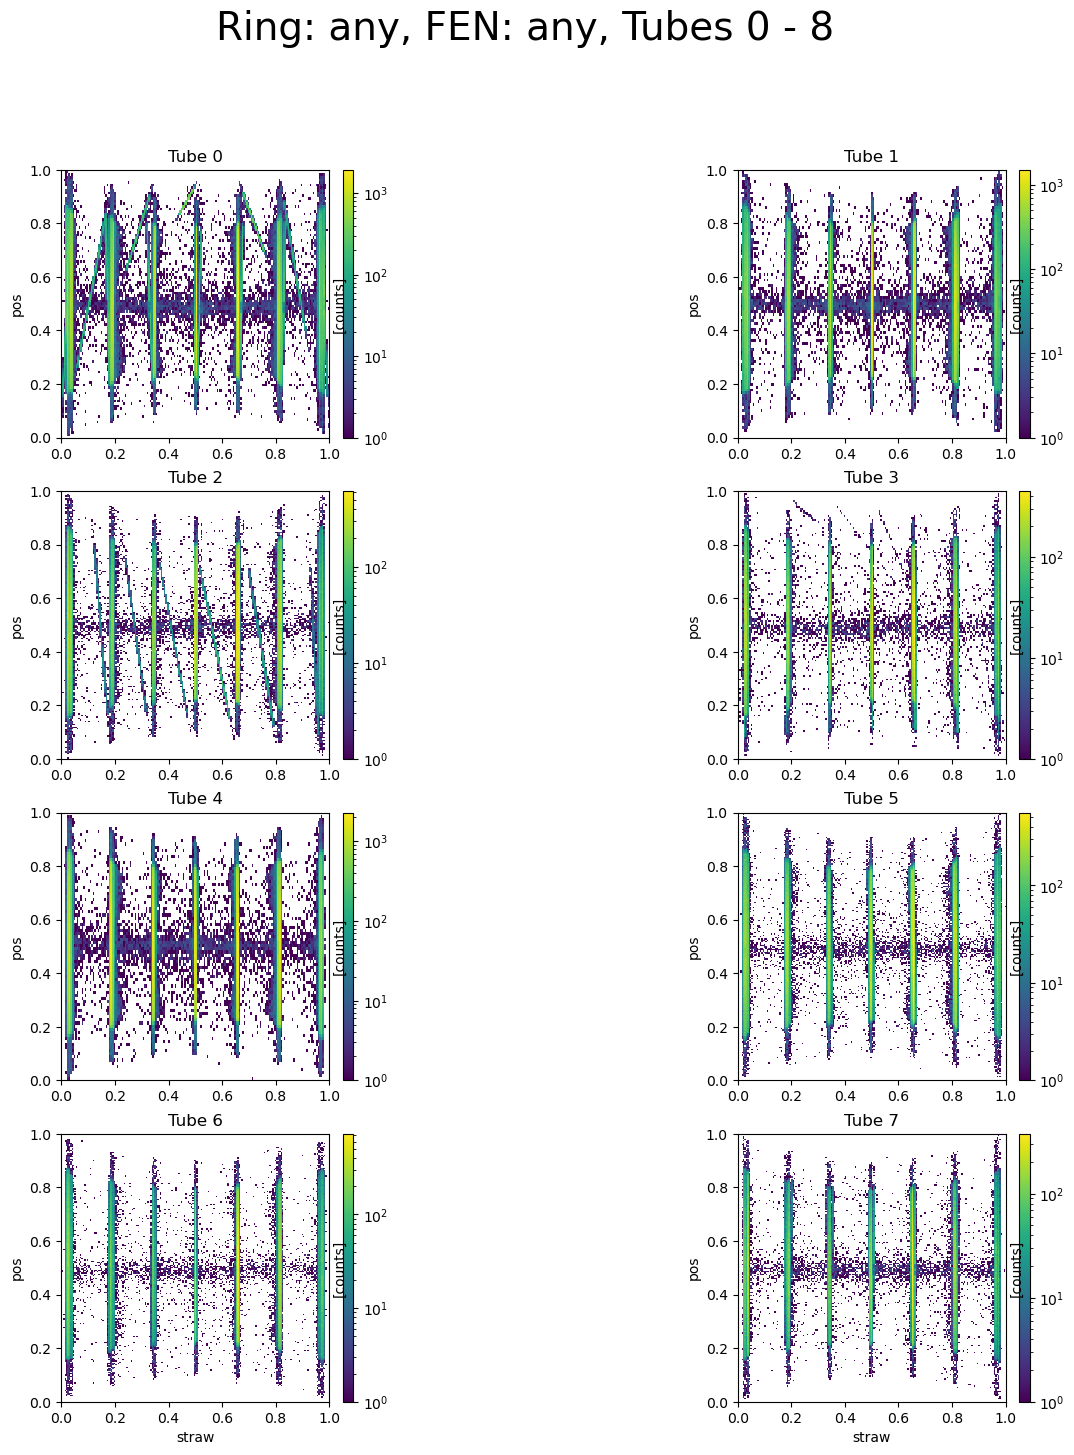

In [11]:
filename = '60383loki_20220304-061312_00000.h5'
filename = f'/Users/wojciechpotrzebowski/SCIPP_SPACE/detector-calibration/data/{filename}'

#Plotting all data
ring = -1
fen = -1
outdir = filename[:5]
load_and_process_data(filename, ring, fen, outdir)

In [12]:
#Few configurations that give rise to different images
i = 3
fen = 15

#i = 2
#fen = 1

#Noisy data 
#i = 4
#fen = 7

#i = 2
#fen = 3

ring = -1
rgrp = array(dims=['ring'], values=[ring])
fgrp = array(dims=['fen'], values=[fen])
tgrp = array(dims=['tube'], values=[i])

dat = readtoscipp(filename)
grp = dat.group(fgrp, tgrp).bins.concat()

In [13]:
histogrammed = grp.hist(pos=200, straw=200)
#Flattening image - this is "loosing" information about counts 
tubes = flatten_image(histogrammed, 200, 200, 0)

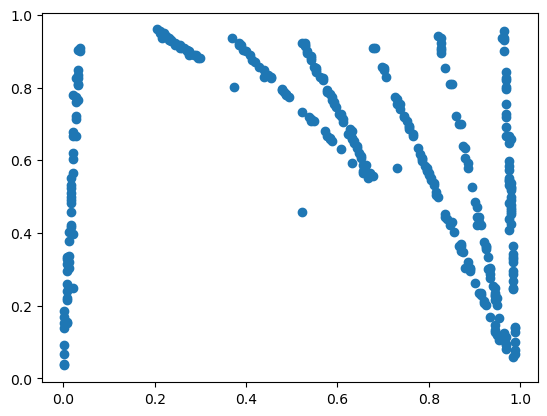

In [14]:
plt.scatter(tubes[:, 0], tubes[:, 1])

## Clustering data 
Few clustering approaches have been tested, however none of them seems to work as a silver bullet
I choose the method called DBSCAN and running it iteratively with the objective of finding 7 clusters. 
For the obvious cases work with any problem for skewed or noisy ones not necessarly 
TODO: Examples of regular, skewed and noisy config

Estimated number of clusters: 5
Estimated number of noise points: 319
[0.00233864 0.00218853]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


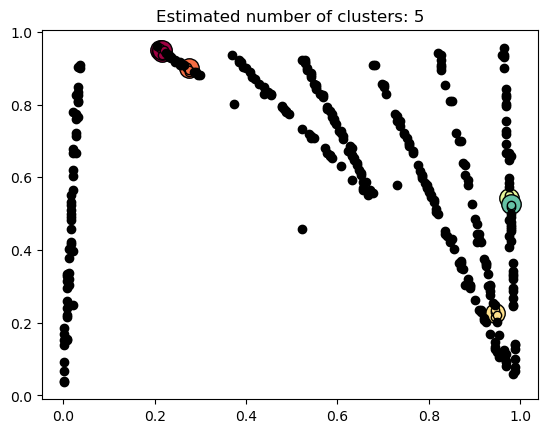

Estimated number of clusters: 25
Estimated number of noise points: 40
[0.00243039 0.01042257]
[0. 0.]
[0.00245506 0.01403785]
[0.00496101 0.00232129]
[0.         0.01771226]
[0.00378904 0.01812986]
[0.02784531 0.02351648]
[0.02479494 0.03468012]
[0.00548461 0.00792872]
[0.04633792 0.11633898]
[0.00233864 0.00379065]
[0.00505926 0.00955966]
[0.0118889  0.03295543]
[0.01021535 0.02851148]
[0.         0.01271423]
[0.00554658 0.00891509]
[0.0091611  0.02865266]
[0.00371248 0.01042257]
[0.01175202 0.04798056]
[0.0166859  0.02226504]
[0. 0.]
[0.00248051 0.        ]
[0.         0.00232129]
[0.00239308 0.04141221]
[0.        0.0252868]


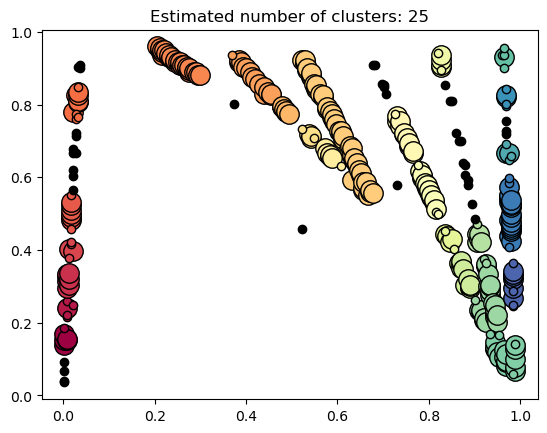

Estimated number of clusters: 9
Estimated number of noise points: 11
[0.00606806 0.13163279]
[0.00371248 0.06025746]
[0.02784531 0.02351648]
[0.08233253 0.11157104]
[0. 0.]
[0.07927554 0.20279756]
[0.00413249 0.02763353]
[0.00248051 0.00696387]
[0.00233864 0.00218853]


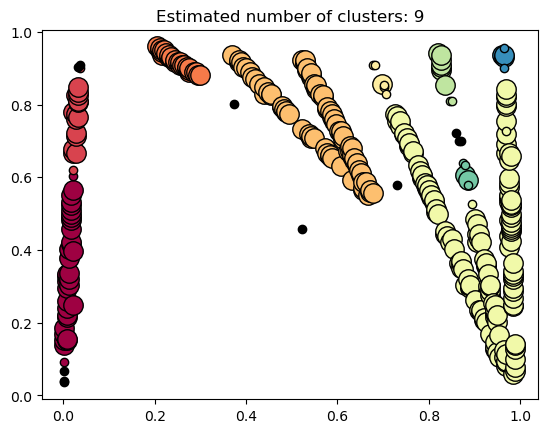

Estimated number of clusters: 4
Estimated number of noise points: 1
[0.01013412 0.24748408]
[0.02784531 0.02351648]
[0.18408774 0.23896632]
[0.00413249 0.02763353]


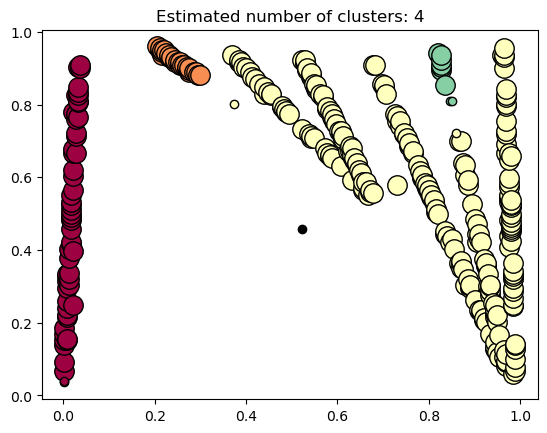

Estimated number of clusters: 2
Estimated number of noise points: 1
[0.01025113 0.25253854]
[0.23531097 0.25136867]


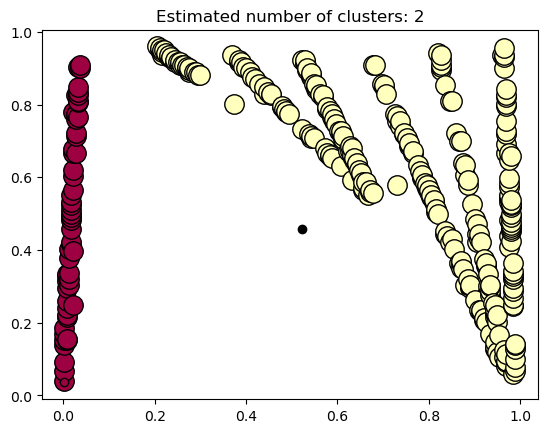

In [15]:
for eps in np.linspace(0.01, 0.1, 5):
    cluster_data(tubes, eps=eps, min_samples=5)

### PCA analysis
The result from clustering or even by slicing in x directions can be used to infer axes for the set of points

In [16]:
straw_edges=[(0,0.1),(0.1,0.25),(0.25,0.4),(0.4,0.55),(0.55,0.7),(0.7,0.85),(0.85,1.0)]

In [17]:
straws = []
for i in range(7):
    straw = generate_straw(tubes, straw_edges[i][0], straw_edges[i][1])
    straws.append(straw)

[[-0.03837803 -0.99926329]
 [ 0.99926329 -0.03837803]]


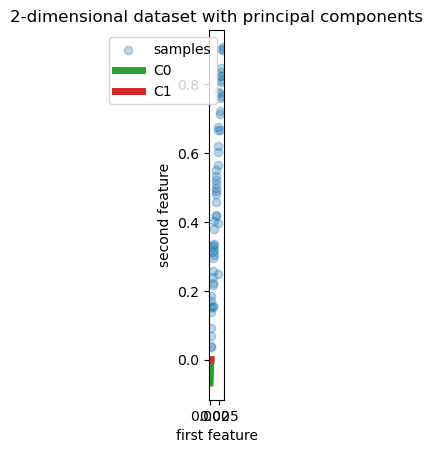

[[ 0.71475142 -0.69937859]
 [-0.69937859 -0.71475142]]


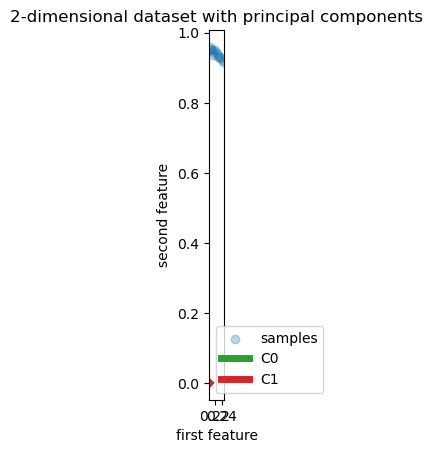

[[ 0.99955977 -0.02966929]
 [-0.02966929 -0.99955977]]


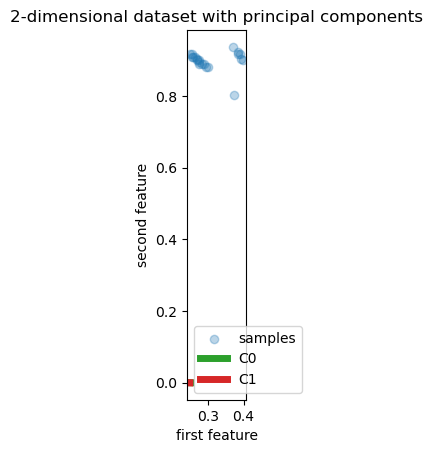

[[ 0.10854499 -0.99409154]
 [-0.99409154 -0.10854499]]


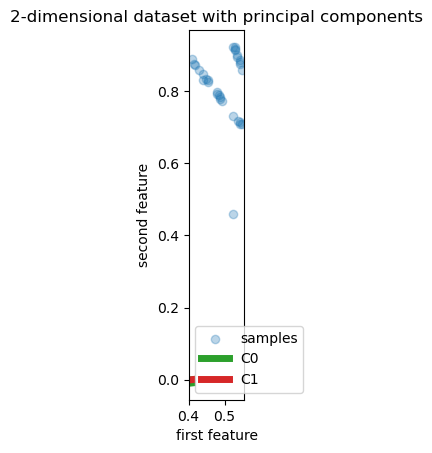

[[-0.20991418  0.97771982]
 [ 0.97771982  0.20991418]]


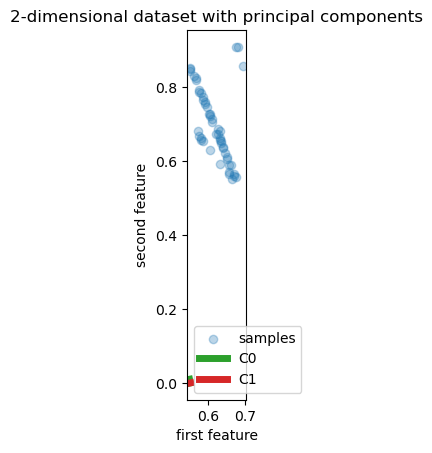

[[-0.08143457  0.99667869]
 [ 0.99667869  0.08143457]]


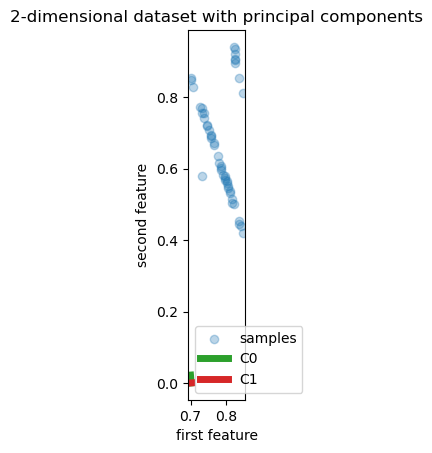

[[-0.00832907  0.99996531]
 [-0.99996531 -0.00832907]]


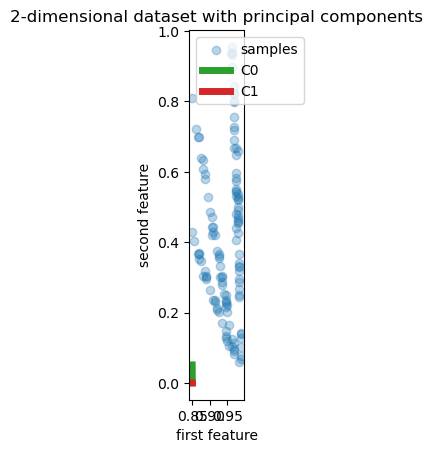

In [18]:
straw_len = 25
pos_len = 200
for straw in straws:
#     Z = flatten_image(straw, straw_len, pos_len, 0)
    #plt.plot(straw[:,0], straw[:,1], 'o')
    pca = PCA(n_components=2).fit(straw)
    print(pca.components_)
    plot_pca(straw, pca)

### Simple metrics based on counts

In [19]:
#Few configurations that give rise to different images
i = 3
fen = 15

i = 2
fen = 1

#Noisy data 
i = 4
fen = 7

i = 2
fen = 3

i = 0 
fen =3 

ring = -1
rgrp = array(dims=['ring'], values=[ring])
fgrp = array(dims=['fen'], values=[fen])
tgrp = array(dims=['tube'], values=[i])

dat = readtoscipp(filename)
grp = dat.group(fgrp, tgrp).bins.concat()
histogrammed = grp.hist(pos=200, straw=200)

In [20]:
all_counts = histogrammed.values.sum()

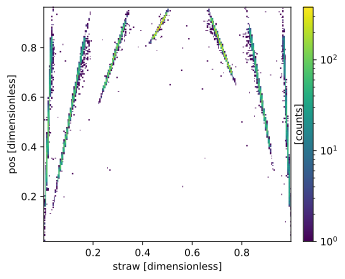

In [21]:
histogrammed.plot(aspect=1.,norm='log')

In [22]:
straw_lens=[(0,25),(29,54),(57,82),(86,111),(114,140),(143,168),(171,200)]
straw1 = histogrammed['straw', :25]
straw2 = histogrammed['straw', 29:54]
straw3 = histogrammed['straw', 57:82]
straw4 = histogrammed['straw', 86:111]
straw5 = histogrammed['straw', 114:140]
straw6 = histogrammed['straw', 143:168]
straw7 = histogrammed['straw', 171:]

In [23]:
pos1 = histogrammed['pos', :25]
pos2 = histogrammed['pos', 29:54]
pos3 = histogrammed['pos', 57:82]
pos4 = histogrammed['pos', 86:111]
pos5 = histogrammed['pos', 114:140]
pos6 = histogrammed['pos', 143:168]
pos7 = histogrammed['pos', 171:]

In [24]:
rates_straw = [straw1.values.sum()/all_counts,
straw2.values.sum()/all_counts,
straw3.values.sum()/all_counts,
straw4.values.sum()/all_counts,
straw5.values.sum()/all_counts,
straw6.values.sum()/all_counts,
straw7.values.sum()/all_counts]

In [25]:
rates_pos = [pos1.values.sum()/all_counts,
pos2.values.sum()/all_counts,
pos3.values.sum()/all_counts,
pos4.values.sum()/all_counts,
pos5.values.sum()/all_counts,
pos6.values.sum()/all_counts,
pos7.values.sum()/all_counts]

For the regularly distributed signals this function reaches maximum around 3,4. 

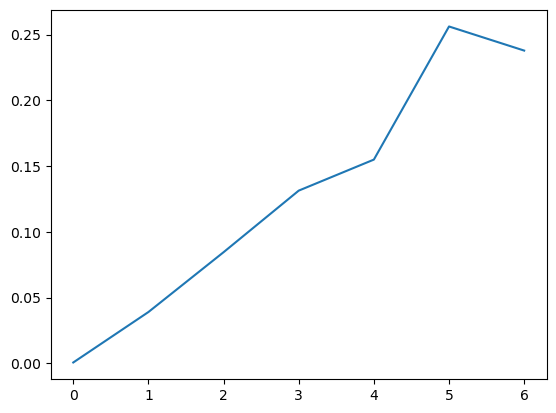

In [26]:
plt.plot(rates_pos)

No clear conclusion about below one

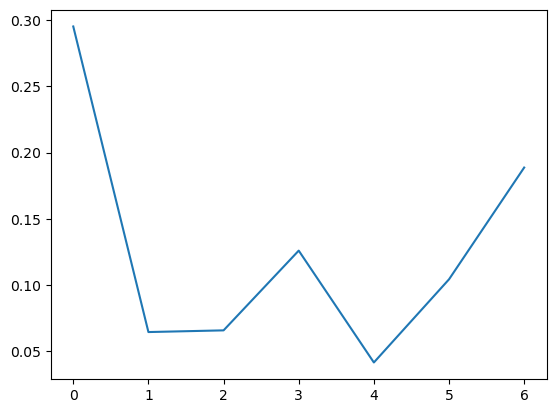

In [27]:
plt.plot(rates_straw)